In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
!pip install pytorch_lightning
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.3 MB/s eta 0:00:00


In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
import cv2
import numpy as np
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.image as img
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import F1Score
from lightning.pytorch import seed_everything
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import classification_report

In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/BT5153_FinalProject'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/BT5153_FinalProject
/content/gdrive/.shortcut-targets-by-id/1E1Y94YFrnEb-mWKsVJpBhTngD-Kqv3FZ/BT5153_FinalProject


# Data Preprocessing

In [ ]:
environment_to_id = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, environment=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.environment = environment
        environment_to_id = {
            'buildings': 0,
            'forest': 1,
            'glacier': 2,
            'mountain': 3,
            'sea': 4,
            'street': 5
        }

        categories = ['AI', 'Real']
        for category in categories:
            category_path = os.path.join(root_dir, category)
            for env in os.listdir(category_path):
                if environment is not None and env != environment:
                    continue  # Skip other environments if a specific one is set
                environment_path = os.path.join(category_path, env)
                if not os.path.isdir(environment_path):
                    continue
                for image_name in os.listdir(environment_path):
                    image_path = os.path.join(environment_path, image_name)
                    if os.path.isfile(image_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                        self.image_paths.append(image_path)
                        self.labels.append(0 if category == 'AI' else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [ ]:
root_dir = '/content/gdrive/My Drive/BT5153_FinalProject/Dataset'

# dataset for different environments
dataset_street = ImageDataset(root_dir, transform=transform, environment='street')
dataloader_street = torch.utils.data.DataLoader(dataset_street, batch_size=32, shuffle=True)

dataset_buildings = ImageDataset(root_dir, transform=transform, environment='buildings')
dataloader_buildings = torch.utils.data.DataLoader(dataset_buildings, batch_size=32, shuffle=True)

dataset_forest = ImageDataset(root_dir, transform=transform, environment='forest')
dataloader_forest = torch.utils.data.DataLoader(dataset_forest, batch_size=32, shuffle=True)

dataset_glacier = ImageDataset(root_dir, transform=transform, environment='glacier')
dataloader_glacier = torch.utils.data.DataLoader(dataset_glacier, batch_size=32, shuffle=True)

dataset_mountain = ImageDataset(root_dir, transform=transform, environment='mountain')
dataloader_mountain = torch.utils.data.DataLoader(dataset_mountain, batch_size=32, shuffle=True)

dataset_sea = ImageDataset(root_dir, transform=transform, environment='sea')
dataloader_sea = torch.utils.data.DataLoader(dataset_sea, batch_size=32, shuffle=True)

images_street, labels_street = next(iter(dataloader_street))
images_buildings, labels_buildings = next(iter(dataloader_buildings))
images_forest, labels_forest = next(iter(dataloader_forest))
images_glacier, labels_glacier = next(iter(dataloader_glacier))
images_mountain, labels_mountain = next(iter(dataloader_mountain))
images_sea, labels_sea = next(iter(dataloader_sea))


# Load ResNet50 model

In [ ]:
class BinaryClassificationResNet50(pl.LightningModule):
    def __init__(self, num_classes=2, learning_rate=1e-3):
        super(BinaryClassificationResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, num_classes)

        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        # Define F1 score metric for each phase
        self.train_f1 = F1Score(task='binary', average='macro')
        self.val_f1 = F1Score(task='binary', average='macro')
        self.test_f1 = F1Score(task='binary', average='macro')
        #self.training_step_outputs = []
        #self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        return self.resnet50(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, labels = batch[:2]
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        self.train_f1.update(preds, labels)
        # Log loss and F1 directly here, letting PL handle averaging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        train_f1_score = self.train_f1.compute()  # Computes current value of F1
        self.log('train_f1', train_f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.train_f1.reset()  # Reset F1 after logging to avoid accumulation over batches
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[:2]
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        self.val_f1.update(preds, labels)
        # Directly log loss and F1
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        val_f1_score = self.val_f1.compute()
        self.log('val_f1', val_f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_f1.reset()

    def test_step(self, batch, batch_idx):
        inputs, labels, env_labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        self.test_f1.update(preds, labels)
        self.test_step_outputs.append ({'loss': loss, 'test_preds': preds, 'test_labels': labels, 'env_labels': env_labels})

    def on_test_epoch_end(self):
        # Aggregate the losses
        losses = torch.stack([x['loss'] for x in self.test_step_outputs])
        avg_loss = torch.mean(losses)
        self.log('test_loss', avg_loss, on_epoch=True, prog_bar=True, logger=True)

        # Compute and log the F1 score for validation
        test_f1_score = self.test_f1.compute()  # Compute the F1 score
        self.log('test_f1', test_f1_score, on_epoch=True, prog_bar=True, logger=True)

        # Concatenate all predictions, labels, and environment labels from each batch
        all_preds = torch.cat([x['test_preds'] for x in self.test_step_outputs], dim=0)
        all_labels = torch.cat([x['test_labels'] for x in self.test_step_outputs], dim=0)
        all_envs = torch.cat([x['env_labels'] for x in self.test_step_outputs], dim=0)

        # Convert to CPU and to numpy arrays for use with sklearn metrics
        all_preds = all_preds.cpu().numpy()
        all_labels = all_labels.cpu().numpy()
        all_envs = all_envs.cpu().numpy()

        # Reverse the mapping from environment ID to name
        id_to_environment = {v: k for k, v in environment_to_id.items()}

        # Iterate over each environment and compute the classification report
        for env_id, env_name in id_to_environment.items():
            env_mask = (all_envs == env_id)
            env_labels = all_labels[env_mask]
            env_preds = all_preds[env_mask]

            # Compute the classification report for this environment
            report = classification_report(env_labels, env_preds, output_dict=True)

            # Print the classification report
            print(f'Environment: {env_name}\n', classification_report(env_labels, env_preds))
        self.test_f1.reset()
        self.test_step_outputs.clear()

In [ ]:
model = BinaryClassificationResNet50()

# Load the pretrained weights from the checkpoint
checkpoint_path = 'model_checkpoints/best_model_2-v1.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

# Transfer model to GPU if available
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 29.6MB/s]


# gradCAM for the last layer

In [ ]:
root_dir = '/content/gdrive/My Drive/BT5153_FinalProject/Comparison dataset'
environments = ['street', 'buildings', 'forest', 'glacier', 'mountain', 'sea']
dataloaders = {}

for env in environments:
    dataset = ImageDataset(root_dir, transform=transform, environment=env)
    dataloaders[env] = DataLoader(dataset, batch_size=6, shuffle=True)


dataloader_buildings = dataloaders['buildings']
dataloader_forest = dataloaders['forest']
dataloader_glacier = dataloaders['glacier']
dataloader_mountain = dataloaders['mountain']
dataloader_sea = dataloaders['sea']
dataloader_street = dataloaders['street']

In [ ]:
print(model)

BinaryClassificationResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [ ]:
# Prepare for Grad-CAM
target_layers = [model.resnet50.layer4[-1]]  # last layer
cam = GradCAM(model=model, target_layers=target_layers)

dataloaders = [
    (dataloader_street, "Street"),
    (dataloader_buildings, "Buildings"),
    (dataloader_forest, "Forest"),
    (dataloader_glacier, "Glacier"),
    (dataloader_mountain, "Mountain"),
    (dataloader_sea, "Sea")
]

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Start a new figure
plt.figure(figsize=(24, 36))

# Iterate over environments
for env_index, (dataloader, env_name) in enumerate(dataloaders):
    images, labels = next(iter(dataloader))  # Get a batch from each environment

    for i in range(6):
        img = images[i].unsqueeze(0).to(device)  # Prepare image
        output = model(img)
        prediction = output.argmax(dim=1)

        # Generate CAM heatmap
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

        # Plot each CAM image in a subplot
        plt.subplot(6, 6, env_index * 6 + i + 1)  # Calculate the subplot position
        plt.imshow(cam_image)
        plt.title(f'{env_name} - Label: {labels[i].item()}, Pred: {prediction.item()}')
        plt.axis('off')

# Show the plot after adding all subplots
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Prepare for Grad-CAM
target_layers = [model.resnet50.layer3[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

dataloaders = [
    (dataloader_street, "Street"),
    (dataloader_buildings, "Buildings"),
    (dataloader_forest, "Forest"),
    (dataloader_glacier, "Glacier"),
    (dataloader_mountain, "Mountain"),
    (dataloader_sea, "Sea")
]

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Start a new figure
plt.figure(figsize=(24, 36))

# Iterate over environments
for env_index, (dataloader, env_name) in enumerate(dataloaders):
    images, labels = next(iter(dataloader))  # Get a batch from each environment

    for i in range(6):
        img = images[i].unsqueeze(0).to(device)  # Prepare image
        output = model(img)
        prediction = output.argmax(dim=1)

        # Generate CAM heatmap
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

        # Plot each CAM image in a subplot
        plt.subplot(6, 6, env_index * 6 + i + 1)  # Calculate the subplot position
        plt.imshow(cam_image)
        plt.title(f'{env_name} - Label: {labels[i].item()}, Pred: {prediction.item()}')
        plt.axis('off')

# Show the plot after adding all subplots
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [11]:
# Prepare for Grad-CAM
target_layers = [model.resnet50.layer2[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Start a new figure
plt.figure(figsize=(24, 36))

# Iterate over environments
for env_index, (dataloader, env_name) in enumerate(dataloaders):
    images, labels = next(iter(dataloader))  # Get a batch from each environment

    for i in range(6):
        img = images[i].unsqueeze(0).to(device)  # Prepare image
        output = model(img)
        prediction = output.argmax(dim=1)

        # Generate CAM heatmap
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

        # Plot each CAM image in a subplot
        plt.subplot(6, 6, env_index * 6 + i + 1)  # Calculate the subplot position
        plt.imshow(cam_image)
        plt.title(f'{env_name} - Label: {labels[i].item()}, Pred: {prediction.item()}')
        plt.axis('off')

# Show the plot after adding all subplots
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Use Grad-CAM for error explanation

In [ ]:
plt.figure(figsize=(24, 36))
subplot_idx = 1
for dataloader, env_name in dataloaders:
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    # Keep looping over the DataLoader until we find 3 incorrect predictions
    while len(incorrect_images) < 3:
        images, labels = next(iter(dataloader))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Check for incorrect predictions
        for img, label, prediction in zip(images, labels, predictions):
            if label != prediction and len(incorrect_images) < 3:
                incorrect_images.append(img.cpu())
                incorrect_labels.append(label.item())
                incorrect_predictions.append(prediction.item())

    # Generate and display Grad-CAM heatmaps for the incorrect predictions
    for i in range(3):
        img = incorrect_images[i].unsqueeze(0).to(device)
        output = model(img)
        prediction = incorrect_predictions[i]

        # Generate CAM heatmap
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        img_cpu = img.squeeze().numpy().transpose(1, 2, 0)
        cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

        # Plot original image
        plt.subplot(6, 6, subplot_idx)  # Adjust for 3 per row per environment
        plt.imshow(img_cpu)
        plt.title(f'{env_name} - Label: {incorrect_labels[i]}, Pred: {prediction}')
        plt.axis('off')

        # Plot CAM image
        plt.subplot(6, 6, subplot_idx + 1)  # Next slot for CAM images
        plt.imshow(cam_image)
        plt.title(f'{env_name} - Grad-CAM')
        plt.axis('off')

        subplot_idx += 2  # Move index to the next pair

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

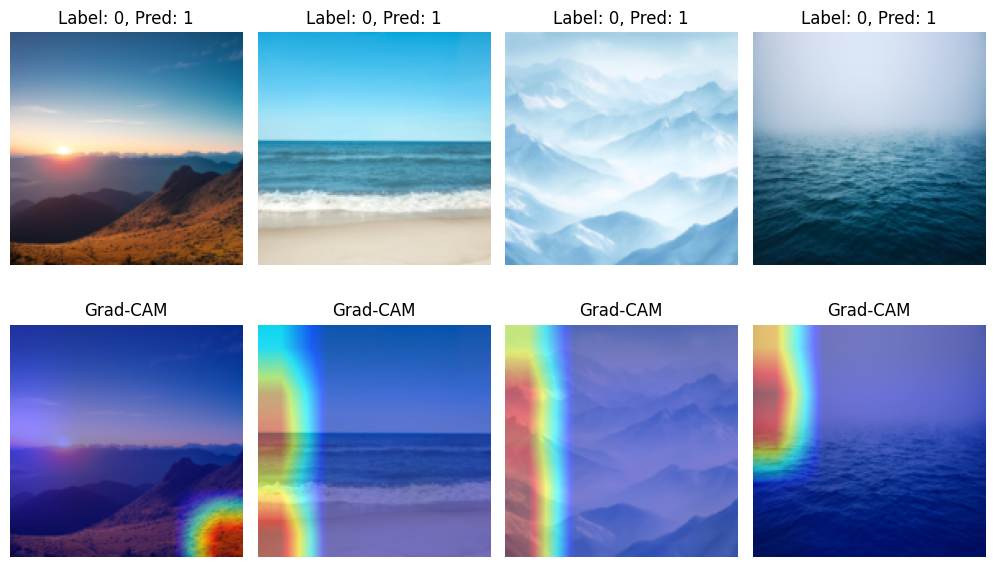

In [ ]:
# labled 0 and predicted 1

dataset = ImageDataset(root_dir, transform=transform, environment=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

plt.figure(figsize=(15, 6))  # Adjust size as needed

# Collecting images
collected_images = []
collected_labels = []
collected_predictions = []
count = 0  # To keep track of how many images we have collected

for images, labels in dataloader:
    if count >= 6:
        break  # Stop if we have collected enough images
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predictions = outputs.argmax(dim=1)

    for img, label, prediction in zip(images, labels, predictions):
        if label.item() == 0 and prediction.item() == 1:
            collected_images.append(img.cpu())
            collected_labels.append(label.item())
            collected_predictions.append(prediction.item())
            count += 1
            if count == 6:
                break

# Generating and displaying Grad-CAM heatmaps
for i, img in enumerate(collected_images):
    img = img.unsqueeze(0).to(device)
    output = model(img)

    # Generate CAM heatmap
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = img.squeeze().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plot original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(img_cpu)
    plt.title(f'Label: {collected_labels[i]}, Pred: {collected_predictions[i]}')
    plt.axis('off')

    # Plot CAM image
    plt.subplot(2, 6, i + 7)
    plt.imshow(cam_image)
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()

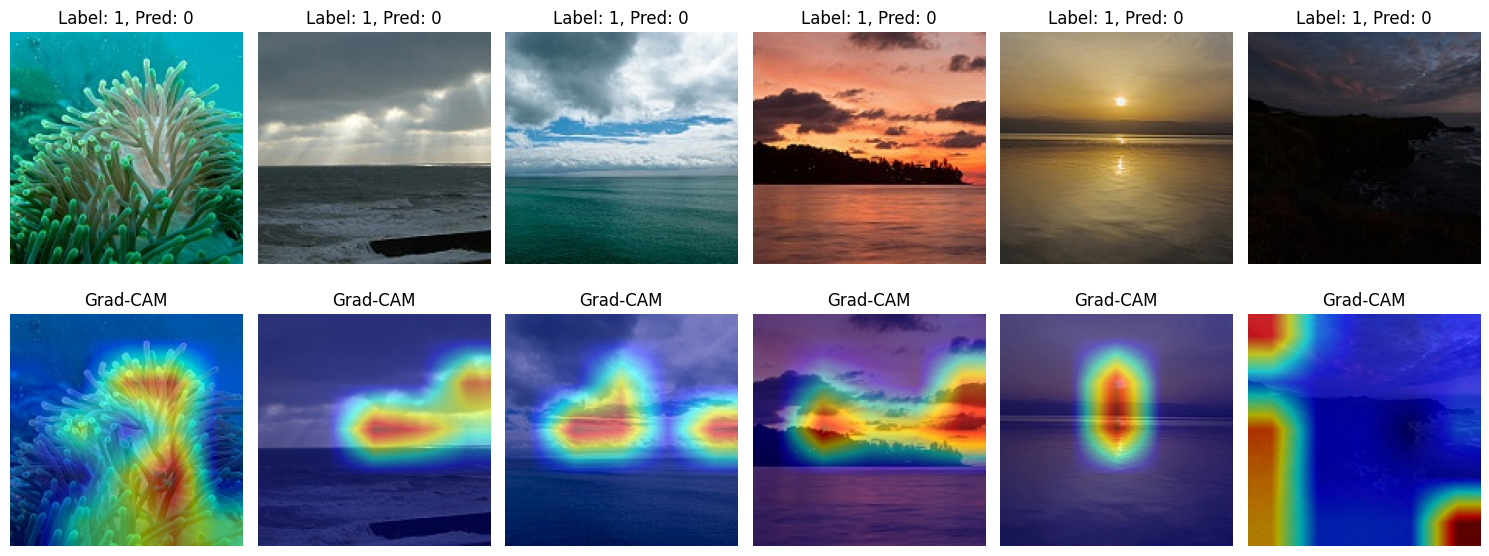

In [ ]:
# labled 1 and predicted 0

dataset = ImageDataset(root_dir, transform=transform, environment=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

plt.figure(figsize=(15, 6))  # Adjust size as needed

# Collecting images
collected_images = []
collected_labels = []
collected_predictions = []
count = 0  # To keep track of how many images we have collected

for images, labels in dataloader:
    if count >= 6:
        break  # Stop if we have collected enough images
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predictions = outputs.argmax(dim=1)

    for img, label, prediction in zip(images, labels, predictions):
        if label.item() == 1 and prediction.item() == 0:
            collected_images.append(img.cpu())
            collected_labels.append(label.item())
            collected_predictions.append(prediction.item())
            count += 1
            if count == 6:
                break

# Generating and displaying Grad-CAM heatmaps
for i, img in enumerate(collected_images):
    img = img.unsqueeze(0).to(device)
    output = model(img)

    # Generate CAM heatmap
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = img.squeeze().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plot original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(img_cpu)
    plt.title(f'Label: {collected_labels[i]}, Pred: {collected_predictions[i]}')
    plt.axis('off')

    # Plot CAM image
    plt.subplot(2, 6, i + 7)
    plt.imshow(cam_image)
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()